In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 377.0MB 57kB/s 


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown sha

It: 0, Loss: 3.771e+04, Time: 1.21
It: 100, Loss: 5.579e+02, Time: 1.06
It: 200, Loss: 2.016e+02, Time: 1.01
It: 300, Loss: 1.549e+02, Time: 1.01
It: 400, Loss: 1.168e+02, Time: 1.02
It: 500, Loss: 8.643e+01, Time: 1.02
It: 600, Loss: 6.319e+01, Time: 0.99
It: 700, Loss: 4.626e+01, Time: 1.01
It: 800, Loss: 3.421e+01, Time: 1.04
It: 900, Loss: 2.576e+01, Time: 1.00
It: 1000, Loss: 1.967e+01, Time: 0.99
It: 1100, Loss: 1.529e+01, Time: 1.00
It: 1200, Loss: 1.202e+01, Time: 0.99
It: 1300, Loss: 9.525e+00, Time: 1.02
It: 1400, Loss: 7.610e+00, Time: 1.02
It: 1500, Loss: 6.107e+00, Time: 1.04
It: 1600, Loss: 4.911e+00, Time: 0.99
It: 1700, Loss: 3.945e+00, Time: 1.04
It: 1800, Loss: 3.160e+00, Time: 1.02
It: 1900, Loss: 2.521e+00, Time: 1.03
It: 2000, Loss: 1.998e+00, Time: 1.00
It: 2100, Loss: 1.573e+00, Time: 1.05
It: 2200, Loss: 1.230e+00, Time: 1.00
It: 2300, Loss: 9.535e-01, Time: 0.99
It: 2400, Loss: 7.326e-01, Time: 1.00
It: 2500, Loss: 5.582e-01, Time: 1.02
It: 2600, Loss: 4.227e-0

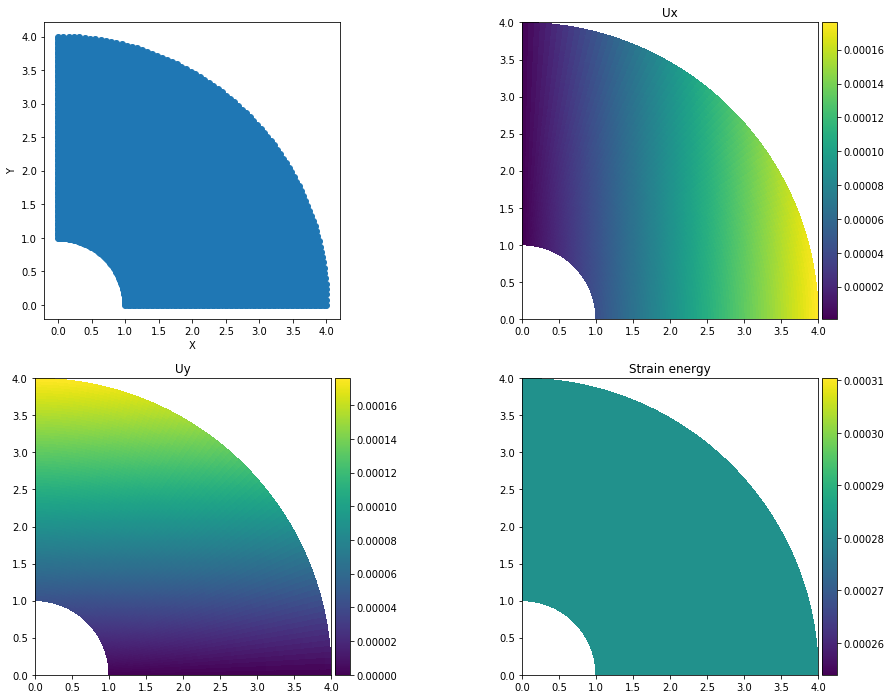

In [0]:
    # MAIN PINN Tensorflow python code 
    # Author : Tittu Varghese Mathew, in collaboration with Sundar, Hrishikesh and Pramod 
    # Date : 6th September 2019 
    # Reference paper : An Energy Approach to the Solution of Partial Differential
    # Equations in Computational Mechanics via Machine Learning: Concepts, Implementation and Applications

    # Import the necessary packages 
    import tensorflow as tf
    import numpy as np
    import matplotlib.pyplot as plt
    import scipy.io
    from scipy.interpolate import griddata
    import time
    from itertools import product, combinations
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.gridspec as gridspec
    import pylab
    import math 
    from operator import add
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # To set the random seed number to a fixed value so that 
    # every time you run the code, same random numbering will be generated 
    # for replication purposes
    np.random.seed(1234)
    tf.set_random_seed(1234)

    class PhysicsInformedNN:
        # Initialize the class
        # Xcoord,Ycoord,cbnodes,layers,c11,c12,c33,DArea,Npoints,P,Nb
        def __init__(self, x, y, cbn, layers, c11, c12, c33, DArea, NP ,P ,Nb,lbnodes,bbnodes,nodes_interior):        
            
            self.lbnodes = lbnodes          # Left boundary nodes
            self.bbnodes = bbnodes          # Bottom boundary nodes 
            
            self.x = np.array([x]).T
            self.y = np.array([y]).T
            
            X = np.concatenate([self.x, self.y],1) 	# Concatenate along Y direction 
                        
            self.lb = X.min(0)  		    # Find the minimum value in all columns
            self.ub = X.max(0)			    # Find the maximum value in all columns 
                        
            self.c11 = c11  
            self.c12 = c12
            self.c33 = c33
            self.c22 = c11
            self.c21 = c12
            
            self.cbn = np.array([cbn]).T     # Curved boundary node indices 
            self.cbn = tf.convert_to_tensor(self.cbn, dtype=tf.float32)   # boundary conditions stored as tensor
                        
            self.layers = layers        
            self.weights, self.biases = self.initialize_NN(self.layers)          
                        
            self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,log_device_placement=True))              
            self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
            self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])
            
            self.total_var_energy, self.u_pred, self.v_pred = self.net_energy(self.x_tf,self.y_tf)
                                    
            # Equation 28 in the reference paper 
            self.total_var_energy_red = tf.gather(self.total_var_energy,nodes_interior)
            Ninterior_nodes = len(nodes_interior)
            MSE1 = tf.multiply(tf.reduce_sum(self.total_var_energy_red),(DArea/Ninterior_nodes))
            
            
            self.u_cb = tf.gather(self.u_pred, cbn)
            self.v_cb = tf.gather(self.v_pred, cbn)            
            self.uv_cb = tf.concat([self.u_cb, self.v_cb], 0)
            MSE2 = tf.multiply(tf.reduce_sum(self.uv_cb),(DArea*P/Nb))
            self.loss = MSE1 - MSE2 
            
            self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss,method='L-BFGS-B',options={'maxiter': 50000,'maxfun': 50000,'maxcor': 50,'maxls': 50,'ftol' : 1.0 * np.finfo(float).eps})        
            self.optimizer_Adam = tf.train.AdamOptimizer()
            self.train_op_Adam = self.optimizer_Adam.minimize(self.loss) 
            
            init = tf.global_variables_initializer()
            self.sess.run(init)
            # print(self.sess.run(self.weights)[0])
            # print(self.sess.run(self.u_pred))

        ############################################################################
        ####### Class function definition to initialize the weights and biases #####
        ############################################################################
        def initialize_NN(self,layers):        
            # Pass in the layer information 
            weights = [] 		       
            biases = []        
            num_layers = len(layers)    		
            for l in range(0,num_layers-1):
                W = self.xavier_init(size=[layers[l], layers[l+1]])
                b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)			
                
                weights.append(W)
                biases.append(b)        			
            # Both W and b are tf.Variables 
            return weights, biases
        
        ############################################################################
        #######  Function to define the initial weights of ANN #####################
        ############################################################################    
        def xavier_init(self,size):
            in_dim = size[0]
            out_dim = size[1]        
            xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))                
            return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
        
        ########################################################################
        ##############   Function to calculate the variational energy ##########
        ########################################################################
        def net_energy (self,x,y):
            u,v = self.net_uv(x,y)   # u and v are the field values after applying the boundary conditions 
            
            u_x = tf.gradients(u,x)[0]
            v_y = tf.gradients(v,y)[0]
            u_y = tf.gradients(u,y)[0]
            v_x = tf.gradients(v,x)[0]
            u_xy = (u_y + v_x)
            
            sigmaX = self.c11*u_x + self.c12 *v_y
            sigmaY = self.c21*u_x + self.c22 *v_y
            tauXY  = self.c33*u_xy
            
            energy = 0.5*( sigmaX *u_x + sigmaY *v_y + tauXY * u_xy )
                        
            return energy, u, v
               
        ########################################################################
        ####### Class function to impose the boundary conditions  ##############
        ########################################################################
        def net_uv (self,x,y):  ## <- what is vdelta  ?? 
            X = tf.concat([x,y] ,1)     # Concatenate the 'x' and 'y' coordinates 
            uv = self.neural_net(X,self.weights,self.biases)
            
            uNN = uv[:,0:1]             # Retrieve the 'u' displacements 
            vNN = uv[:,1:2]             # Retrieve the 'v' displacements 
            
            # See equation 27 in the reference paper 
            # u = tf.assign(uNN[self.lbnodes], 0.0)            
            u = x * uNN
            # v = tf.assign(vNN[self.bbnodes], 0.0)            
            v = y * vNN
            
            return u, v
            
        ############################################################################
        ###########    Neural Network design #######################################
        ############################################################################
        def neural_net(self, X, weights, biases):
            num_layers = len(weights) + 1		   
            H = 2.0 * (X - self.lb) / ( self.ub - self.lb) - 1.0
            for l in range(0,num_layers-2):
                W = weights[l]
                b = biases[l]
                H = tf.nn.relu(tf.add(tf.matmul(H,W),b))**2    # RELU**2
            W = weights[-1]
            b = biases[-1]
            return tf.add(tf.matmul(H, W), b)  # Last layer consists of only linear activation
        
        ############################################################################
        #########    Function call to train ANN  ###################################
        ############################################################################
        def train(self, nIter): 
            tf_dict = {self.x_tf: self.x, self.y_tf: self.y}        
            start_time = time.time()        
            for it in range(nIter):
                self.sess.run(self.train_op_Adam,tf_dict)            
                if it % 100 == 0:
                    elapsed = time.time() - start_time
                    loss_value = self.sess.run(self.loss, tf_dict)
                    print('It: %d, Loss: %.3e, Time: %.2f' % 
                          (it, loss_value, elapsed))
                    start_time = time.time()  

            self.optimizer.minimize(self.sess,feed_dict = tf_dict,fetches = [self.loss],loss_callback = self.callback)

        ############################################################################
        ##########     Function to perform prediction   ############################
        ############################################################################
        def predict(self):
            tf_dict = {self.x_tf: self.x, self.y_tf: self.y}        
            u_star = self.sess.run(self.u_pred, tf_dict)
            v_star = self.sess.run(self.v_pred, tf_dict)
            energyp = self.sess.run(self.total_var_energy, tf_dict)
            
            return u_star, v_star, energyp
        
        def callback(self, loss):
            print('Loss: %.3e' % (loss))

    ###############################################################################        
    #******************               MAIN file                     **************#
    ###############################################################################
    if __name__ == "__main__": 
        
        # Geometry of the domain 
        Ra = 1       # Inner radius 
        Ro = 4       # Outer radius 
        P = 10       # Internal pressure acting at Ri
        E = 1e5      # Youngs modulus 
        nu = 0.3     # Poisson ratio 
        
        # Plane stress condition (Constitutive matrix elements)
        c11 = E/(1-nu**2) 
        c12 = (E*nu)/(1-nu**2)
        c33 = E/(2*(1+nu))
        
        DArea = (math.pi/4)*(Ro**2 - Ra**2)
        
        # Neural network architecture 
        # 2 inputs corresponds to 'x' and 'y' coordinates
        # 2 ouputs corresponds to 'u' and 'v' dof
        # 3 hidden layers each having 30 neurons
        layers = [2, 3, 3, 2]
        Niter = 10000      # Number of iterations/epoch for training 
        
        # Creat collocation points across the domain
        Nx = 80;      # Number of points along the axial edges 
        Nb = 80;      # Number of points along the circumferential edge 
        theta = 90;   # considering only quarter circle  
        Xcoord = [];  # To store the x coordinates 
        Ycoord = [];  # To store the y coordinates 
        
        Ri = np.linspace(Ra,Ro,Nx)
        dtheta = np.linspace(0,theta,Nb)
        
        for i in range(0,Nb):
            Xcoord = np.append(Xcoord,math.cos(dtheta[i]*math.pi/180)*Ri)
            Ycoord = np.append(Ycoord,math.sin(dtheta[i]*math.pi/180)*Ri)
        
        NPoints = Xcoord.shape[0]
        # Determine the left and bottom boundary nodes 
        lbnodes = np.where(Xcoord < 1e-5)[0]
        #print(lbnodes)
        bbnodes = np.where(Ycoord < 1e-5)[0]    
        #print(bbnodes)
        Rnode = np.sqrt(list(map(add,Xcoord**2,Ycoord**2)))
        Rnode[:] = [xx - Ra for xx in Rnode]
        cbnodes = np.where(Rnode < 1e-5)[0]    
        #print(cbnodes)
        
        Total_bnodes = np.concatenate((lbnodes,bbnodes),axis=0) #              
        Total_bnodes = np.concatenate((Total_bnodes,cbnodes),axis=0)
        Total_bnodes = np.unique(Total_bnodes)
        nodes_interior = np.setdiff1d(range(0,NPoints),Total_bnodes)
        #print(nodes_interior)
        
        # Training the ANN 
        # Create a class object of type PhysiceInformedNN
        model = PhysicsInformedNN(Xcoord,Ycoord,cbnodes,layers,c11,c12,c33,DArea,NPoints,P,Nb,lbnodes,bbnodes,nodes_interior)
        model.train(Niter)   		# 1000 stands for the number of epochs/ iterations for training ANN 
        
        ############################################################################
        #############    Time to plot the solution   ###############################
        ############################################################################
        # Prediction
        u_pred, v_pred, e_pred = model.predict()
        
        # Creating mesh grid data
        count = 0
        XX = np.zeros([Nx,Nb])
        YY = np.zeros([Nx,Nb])
        
        uZZ = np.zeros([Nx,Nb])
        vZZ = np.zeros([Nx,Nb])
        eZZ = np.zeros([Nx,Nb])
        
        for i in range(0,Nb):
            for j in range(0,Nx):
                XX[j][i] = XX[j][i] + Xcoord[count]
                YY[j][i] = YY[j][i] + Ycoord[count]
                uZZ[j][i] = uZZ[j][i] + u_pred[count]
                vZZ[j][i] = vZZ[j][i] + v_pred[count]
                eZZ[j][i] = eZZ[j][i] + e_pred[count]
                count = count+1               
        
        fig = plt.figure(figsize=(16, 12))
        ax1 = fig.add_subplot(221, adjustable='box', aspect=1 )
        ax1.scatter(Xcoord, Ycoord)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        
        
        ax2 = fig.add_subplot(222, adjustable='box', aspect=1)
        ax2.set_title('Ux')
        im2 = ax2.pcolor(XX,YY,uZZ)
        
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im2, cax=cax, orientation='vertical');

        
        ax3 = fig.add_subplot(223, adjustable='box', aspect=1)
        ax3.set_title('Uy')
        im3 = ax3.pcolor(XX,YY,vZZ) 
        
        divider = make_axes_locatable(ax3)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im3, cax=cax, orientation='vertical');
        
        ax4 = fig.add_subplot(224, adjustable='box', aspect=1)
        ax4.set_title('Strain energy')
        im4 = ax4.pcolor(XX,YY,eZZ) 
        
        divider = make_axes_locatable(ax4)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im4, cax=cax, orientation='vertical');
        